<a href="https://colab.research.google.com/github/why-arong/fake-voice-detection/blob/mel-resnet/merged_mel_resnet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget 'https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t' -O open.zip

--2024-07-02 06:38:47--  https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313752771 (3.1G) [application/octet-stream]
Saving to: ‘open.zip’

open.zip            100%[===================>]   3.09G  73.2MB/s    in 35s     

2024-07-02 06:39:22 (90.8 MB/s) - ‘open.zip’ saved [3313752771/3313752771]



In [ ]:
!unzip -q open.zip

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import librosa

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SR = 32000
SEED = 1
BATCH = 32
EPOCH = 10
LR = 1e-4

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, shape=(128, 64), fixed_len=32000):
        self.file_paths = file_paths
        self.labels = labels
        self.shape = shape
        self.fixed_len = fixed_len
        self.length = len(file_paths)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        rand_idx = np.random.randint(0, self.length)
        path1, label1 = self.file_paths[idx], self.labels[idx]
        path2, label2 = self.file_paths[rand_idx], self.labels[rand_idx]

        raw1, _ = librosa.load(path1, sr=SR)
        raw2, _ = librosa.load(path2, sr=SR)

        # padding or clip to convert to fixed length
        raw1 = self._convert_to_fixed_length(raw1)
        raw2 = self._convert_to_fixed_length(raw2)
        raw = raw1 + raw2

        # extract feature
        n_mels = self.shape[0]
        hop_length = self.fixed_len // self.shape[1] + 1
        data = librosa.feature.melspectrogram(y=raw, n_mels=n_mels, hop_length=hop_length)
        data = librosa.power_to_db(data, ref=np.max)

        # normalize and add noise
        data = (data - np.mean(data)) / np.std(data)
        noise = np.random.normal(0, 0.01, data.shape)
        data += noise

        data = torch.tensor(data).unsqueeze(0)
        fake_included = int(label1 == 0 or label2 == 0)
        real_included = int(label1 == 1 or label2 == 1)
        label = torch.tensor([fake_included, real_included])

        return data, label

    def _convert_to_fixed_length(self, raw):
        length = len(raw)

        if length < self.fixed_len:
            to_pad = self.fixed_len - length
            left_pad = np.random.randint(0, to_pad + 1)
            right_pad = to_pad - left_pad
            raw = np.pad(raw, (left_pad, right_pad), mode='constant')

        else:
            start = np.random.randint(0, length - self.fixed_len + 1)
            raw = raw[start:start + self.fixed_len]

        return raw

In [ ]:
train = pd.read_csv("train.csv")
train["label"] = train["label"].apply(lambda x: 1 if x == "real" else 0)
train.head()

,id,path,label
0,RUNQPNJF,./train/RUNQPNJF.ogg,1
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,0
2,RDKEKEVX,./train/RDKEKEVX.ogg,1
3,QYHJDOFK,./train/QYHJDOFK.ogg,1
4,RSPQNHAO,./train/RSPQNHAO.ogg,1


In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train["path"].values, train["label"].values, test_size=0.2, stratify=train["label"]
)

train_dataset = AudioDataset(train_paths, train_labels)
valid_dataset = AudioDataset(valid_paths, valid_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, stride=stride)
        self.conv2 = ConvBlock(out_channels, out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + shortcut
        x = self.relu(x)
        return x

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = ConvBlock(1, 16)
        self.res1 = ResBlock(16, 16)
        self.res2 = ResBlock(16, 32, stride=2)
        self.res3 = ResBlock(32, 32)
        self.res4 = ResBlock(32, 64, stride=2)
        self.res5 = ResBlock(64, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
model = AudioClassifier(2).to(device)

summary(model, input_size=(1, 128, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 128, 64]             160
       BatchNorm2d-2          [-1, 16, 128, 64]              32
              ReLU-3          [-1, 16, 128, 64]               0
         ConvBlock-4          [-1, 16, 128, 64]               0
          Identity-5          [-1, 16, 128, 64]               0
            Conv2d-6          [-1, 16, 128, 64]           2,320
       BatchNorm2d-7          [-1, 16, 128, 64]              32
              ReLU-8          [-1, 16, 128, 64]               0
         ConvBlock-9          [-1, 16, 128, 64]               0
           Conv2d-10          [-1, 16, 128, 64]           2,320
      BatchNorm2d-11          [-1, 16, 128, 64]              32
             ReLU-12          [-1, 16, 128, 64]               0
        ConvBlock-13          [-1, 16, 128, 64]               0
             ReLU-14          [-1, 16, 

In [ ]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    total_loss = 0
    count = 0
    correct = 0

    if train:
        model.train()
    else:
        model.eval()

    for data, labels in tqdm(dataloader, desc="Training" if train else "Evaluating"):
        data = data.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        count += len(labels) * 2
        correct += ((outputs > 0.5).float() == labels).sum().item()

    return total_loss / count, correct / count

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

best_accuracy = 0
best_model = None

for epoch in range(EPOCH):
    print(f"Epoch {epoch}")

    train_loss, train_accuracy = run_epoch(model, train_dataloader, optimizer, criterion, train=True)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")

    valid_loss, valid_accuracy = run_epoch(model, valid_dataloader, optimizer, criterion, train=False)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Test Loss: {valid_loss:.4f}")
    print(f"Test Accuracy: {valid_accuracy:.4f}")

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_model = model

Epoch 0


Training: 100%|██████████| 1386/1386 [20:28<00:00,  1.13it/s]


Train Loss: 0.0046
Train Accuracy: 0.8604


Evaluating: 100%|██████████| 347/347 [05:16<00:00,  1.10it/s]


Test Loss: 0.0034
Test Accuracy: 0.9068
Epoch 1


Training: 100%|██████████| 1386/1386 [21:42<00:00,  1.06it/s]


Train Loss: 0.0030
Train Accuracy: 0.9144


Evaluating: 100%|██████████| 347/347 [05:48<00:00,  1.00s/it]


Test Loss: 0.0027
Test Accuracy: 0.9245
Epoch 2


Training: 100%|██████████| 1386/1386 [22:04<00:00,  1.05it/s]


Train Loss: 0.0026
Train Accuracy: 0.9265


Evaluating: 100%|██████████| 347/347 [05:12<00:00,  1.11it/s]


Test Loss: 0.0042
Test Accuracy: 0.8711
Epoch 3


Training: 100%|██████████| 1386/1386 [21:16<00:00,  1.09it/s]


Train Loss: 0.0024
Train Accuracy: 0.9359


Evaluating: 100%|██████████| 347/347 [05:06<00:00,  1.13it/s]


Test Loss: 0.0029
Test Accuracy: 0.9226
Epoch 4


Training: 100%|██████████| 1386/1386 [20:57<00:00,  1.10it/s]


Train Loss: 0.0022
Train Accuracy: 0.9408


Evaluating: 100%|██████████| 347/347 [05:13<00:00,  1.11it/s]


Test Loss: 0.0018
Test Accuracy: 0.9515
Epoch 5


Training: 100%|██████████| 1386/1386 [20:46<00:00,  1.11it/s]


Train Loss: 0.0021
Train Accuracy: 0.9442


Evaluating: 100%|██████████| 347/347 [05:32<00:00,  1.04it/s]


Test Loss: 0.0031
Test Accuracy: 0.9141
Epoch 6


Training: 100%|██████████| 1386/1386 [21:10<00:00,  1.09it/s]


Train Loss: 0.0020
Train Accuracy: 0.9472


Evaluating: 100%|██████████| 347/347 [05:40<00:00,  1.02it/s]


Test Loss: 0.0032
Test Accuracy: 0.9099
Epoch 7


Training: 100%|██████████| 1386/1386 [21:09<00:00,  1.09it/s]


Train Loss: 0.0019
Train Accuracy: 0.9501


Evaluating: 100%|██████████| 347/347 [04:56<00:00,  1.17it/s]


Test Loss: 0.0021
Test Accuracy: 0.9444
Epoch 8


Training: 100%|██████████| 1386/1386 [21:20<00:00,  1.08it/s]


Train Loss: 0.0018
Train Accuracy: 0.9533


Evaluating: 100%|██████████| 347/347 [05:14<00:00,  1.10it/s]


Test Loss: 0.0022
Test Accuracy: 0.9392
Epoch 9


Training: 100%|██████████| 1386/1386 [22:23<00:00,  1.03it/s]


Train Loss: 0.0017
Train Accuracy: 0.9560


Evaluating: 100%|██████████| 347/347 [05:48<00:00,  1.00s/it]

Test Loss: 0.0018
Test Accuracy: 0.9554


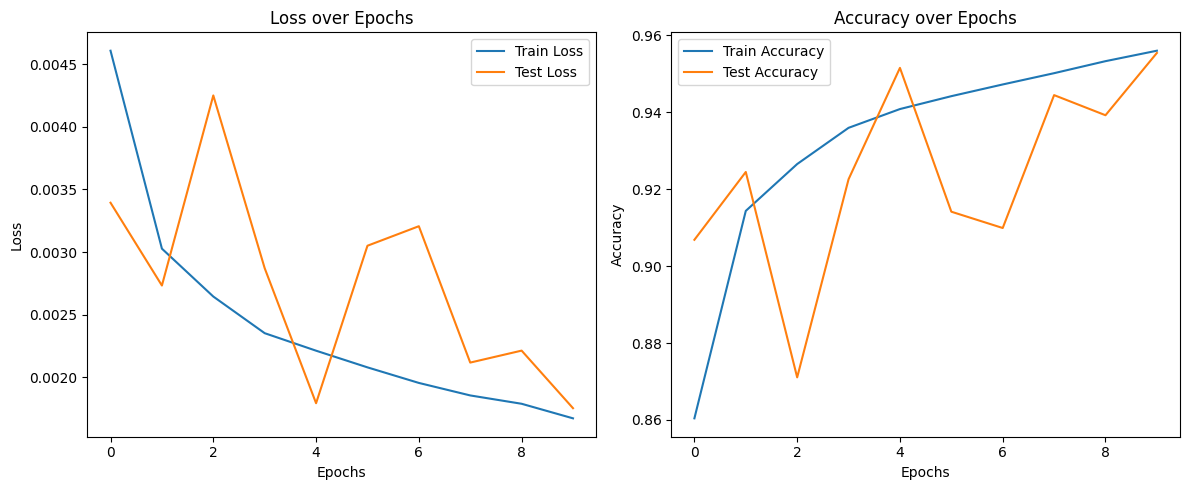

In [ ]:
epochs_range = range(EPOCH)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, valid_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(best_model.state_dict(), "merged_mel_resnet_v1.pth")

In [ ]:
class ChunkedAudioDataset(Dataset):
    def __init__(self, file_paths, shape=(128, 64), fixed_len=32000):
        self.file_paths = file_paths
        self.shape = shape
        self.fixed_len = fixed_len
        self.length = len(file_paths)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        raw, _ = librosa.load(self.file_paths[index], sr=SR)
        n_mels = self.shape[0]
        hop_length = self.fixed_len // self.shape[1] + 1

        data = []
        for chunk in range(5):
            start = chunk * self.fixed_len
            raw_chunk = raw[start:start + self.fixed_len]
            data_chunk = librosa.feature.melspectrogram(y=raw_chunk, n_mels=n_mels, hop_length=hop_length)
            data_chunk = librosa.power_to_db(data_chunk, ref=np.max)

            mean = np.mean(data_chunk)
            std = np.std(data_chunk)
            if std != 0:
                data_chunk = (data_chunk - mean) / std
            else:
                data_chunk = data_chunk - mean
            data.append(data_chunk)

        return torch.tensor(np.array(data)).unsqueeze(1)

In [ ]:
test = pd.read_csv("test.csv")
test_dataset = ChunkedAudioDataset(test["path"].values)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
best_model.eval()
preds = []

for data in tqdm(test_dataloader):
    data = data.squeeze(0)
    data = data.to(device)

    outputs = best_model(data)
    pred = F.sigmoid(outputs).detach().cpu().numpy()
    pred = pred.mean(axis=0)
    preds.append(pred.tolist())

100%|██████████| 50000/50000 [52:47<00:00, 15.79it/s]


In [ ]:
submit = pd.read_csv("sample_submission.csv")
submit.iloc[:, 1:] = preds
submit.to_csv("merged_mel_resnet_v1.csv", index=False)

In [ ]:
submit.head()

,id,fake,real
0,TEST_00000,0.866822,0.989613
1,TEST_00001,0.168012,0.999997
2,TEST_00002,0.736670,0.999616
3,TEST_00003,0.445637,0.999732
4,TEST_00004,0.530695,0.999986


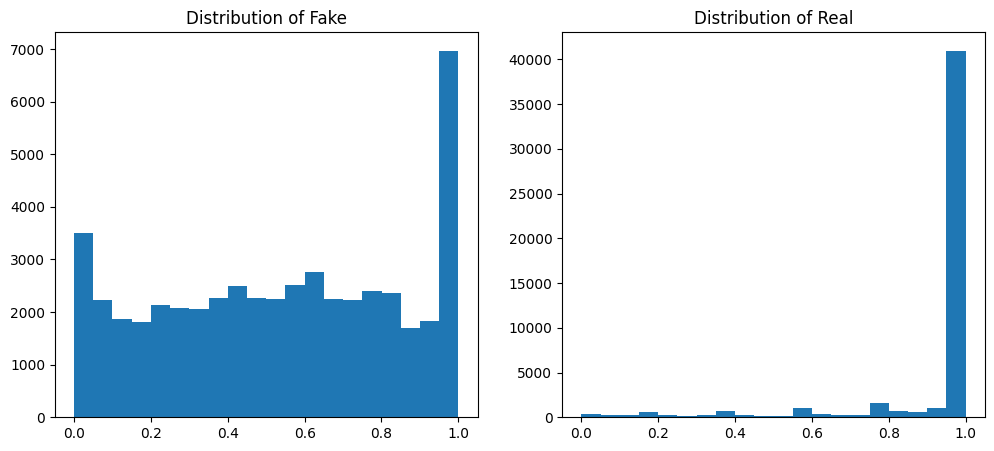

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Distribution of Fake")
plt.hist(submit["fake"], bins=20)

plt.subplot(1, 2, 2)
plt.title("Distribution of Real")
plt.hist(submit["real"], bins=20)
plt.show()